In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
import torch
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, balanced_accuracy_score, euclidean_distances

from scipy.spatial.distance import cosine

from metrics import acc

from data import get_training_and_validation_data
from autoencoder import Autoencoder, VariationalAutoencoder, CategoricalAutoencoder, ConvolutionalCategoricalAutoencoder

model_id = 'YY7MJISJDQ'
model_config = json.load(open(Path('models') / model_id / 'config.json', 'r'))
dataset_id = model_config['dataset_id']
model_type = model_config['model']

X_train, y_train, X_val, y_val = get_training_and_validation_data(
    Path('processed_data'), dataset_id, balanced=True)
# X_mean, X_std = X_train.mean(), X_train.std()
# X_train -= X_mean
# X_train /= X_std
# X_val -= X_mean
# X_val /= X_std

X_min, X_max = X_train.min(), X_train.max()
X_train -= X_min
X_train /= (X_max - X_min)
X_val -= X_min
X_val /= (X_max - X_min)
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
X_val_tensor = torch.from_numpy(X_val).to(torch.float32)

if model_config['model'] == 'vae':
    model = VariationalAutoencoder
elif model_config['model'] == 'cae':
    model = CategoricalAutoencoder
elif model_config['model'] == 'convcae':
    model = ConvolutionalCategoricalAutoencoder
else:
    model = Autoencoder

autoencoder = model(input_dim=X_train.shape[1], **model_config)
autoencoder.load_state_dict(torch.load(Path('models') / model_id / 'ae.pth'))
autoencoder.eval()

if model_type == 'cae' or model_type == 'convcae':
    p = autoencoder.encode(X_train_tensor)
    X_train_enc = autoencoder.reparameterize(p, temperature=model_config['temperature'])
elif model_type == 'vae':
    X_train_mu, X_train_log = autoencoder.encode(X_train_tensor)
    X_train_enc = autoencoder.reparameterize(X_train_mu, X_train_log)
else:
    X_train_enc = autoencoder.encode(X_train_tensor)
X_train_rec = autoencoder.decode(X_train_enc)
print('MSE LOSS:', torch.nn.functional.mse_loss(X_train_tensor, X_train_rec).item())
X_train_rec = X_train_rec.detach().numpy()
X_train_enc = X_train_enc.detach().numpy()

if model_type == 'cae' or model_type == 'convcae':
    p = autoencoder.encode(X_val_tensor)
    X_val_enc = autoencoder.reparameterize(p, temperature=model_config['temperature'])
elif model_type == 'vae':
    X_val_mu, X_val_log = autoencoder.encode(X_val_tensor)
    X_val_enc = autoencoder.reparameterize(X_val_mu, X_val_log)
else:
    X_val_enc = autoencoder.encode(X_val_tensor)
X_val_rec = autoencoder.decode(X_val_enc).detach().numpy()
X_val_enc = X_val_enc.detach().numpy()

MSE LOSS: 0.00014699672465212643


# Visualization

In [ ]:
data = pd.DataFrame(X_train_enc, columns=[f'Dim_{i+1}' for i in range(X_train_enc.shape[1])])
data['Class'] = y_train

# Plot violin plots for each dimension
for column in data.columns[:-1]:  # Exclude the 'Class' column for the plots
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Class', y=column, data=data, hue='Class', palette='muted', legend=False)
    plt.title(f'Violin Plot of {column}')
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.show()

3.9297347775906033e-07


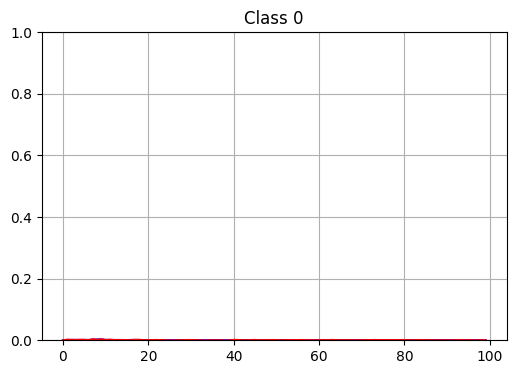

1.6266498850461125e-06


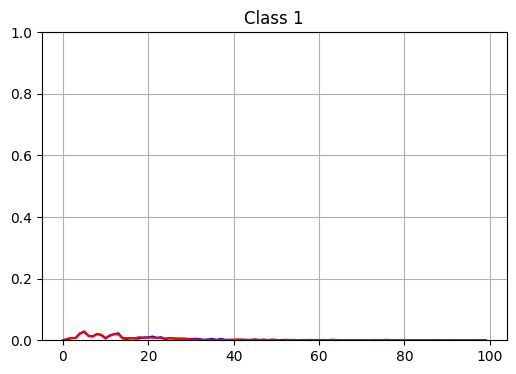

4.114287991204621e-05


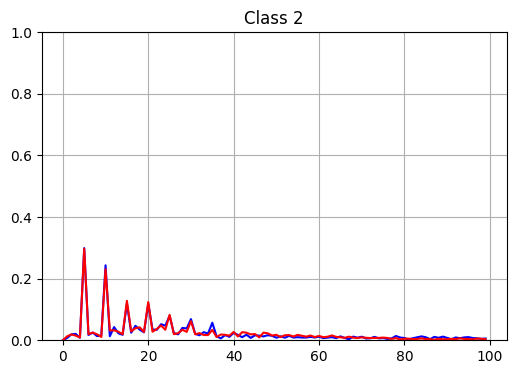

6.416377614077104e-05


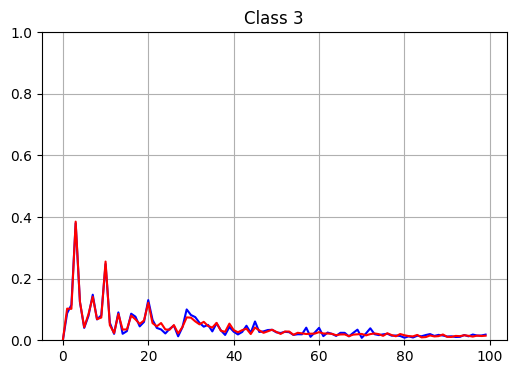

In [2]:
samples = {}
for class_label in range(4):
    indices = np.where(y_train == class_label)[0]
    random_index = np.random.choice(indices)
    samples[class_label] = X_train[random_index], X_train_rec[random_index]

for class_label, (sample, rec_sample) in samples.items():
    plt.figure(figsize=(6, 4))
    plt.plot(sample, color='b')
    plt.plot(rec_sample, color='r')
    print(((sample - rec_sample)**2).mean())
    plt.title(f"Class {class_label}")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

# Evaluation

In [65]:
mean, std = X_train_enc.mean(), X_train_enc.std()
X_train_enc -= mean
X_train_enc /= std
X_val_enc -= mean
X_val_enc /= std

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train_enc)
y_pred = kmeans.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2118
           1       0.83      0.83      0.83     15035
           2       1.00      0.58      0.73      9923
           3       0.94      0.97      0.96      1555

    accuracy                           0.69     28631
   macro avg       0.69      0.59      0.63     28631
weighted avg       0.83      0.69      0.74     28631



/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [93]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_train_enc)
y_pred = gmm.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2118
           1       0.86      0.90      0.88     15035
           2       1.00      0.77      0.87      9923
           3       0.95      0.94      0.95      1555

    accuracy                           0.79     28631
   macro avg       0.70      0.65      0.67     28631
weighted avg       0.85      0.79      0.81     28631



# Distance based clustering

In [2]:
import numpy as np
from distance_matrix import dtw_njit, dtw_c

_ = dtw_njit(np.random.randn(100), np.random.randn(100))
_ = dtw_c(np.random.randn(100), np.random.randn(100))

## Equine data

In [6]:
from data import load_dataset
from distance_matrix import parallel_distance_matrix

N = 2000

X, y = load_dataset(Path('processed_data'), dataset_id='RTAGXFQJ4T') # FFT
# X, y = load_dataset(Path('processed_data'), dataset_id='K6WZL7BWHQ') # Raw
X, y = X[0][:, :, 0], y[0]
indices = np.random.choice(len(X), N)
X, y = X[indices], y[indices]
print(X.shape, np.unique(y, return_counts=True))

distances = parallel_distance_matrix(X)
sums = distances.sum(axis=1)
distances = distances / sums[:, np.newaxis]

(2000, 100) (array([0, 1, 2, 3]), array([114, 771, 966, 149]))


In [ ]:
from sklearn.cluster import AgglomerativeClustering,  DBSCAN
from collections import defaultdict

def cluster_time_series(distances, n_clusters=None):
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels = clustering_model.fit_predict(distances)
    return labels

clusters = cluster_time_series(distances, n_clusters=50)
cluster_label_mapping = defaultdict(list)
for label, cluster in zip(y, clusters):
    cluster_label_mapping[cluster].append(label)

for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l.tolist(), c.tolist()}")
print()
for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l[np.argmax(c)]} ({(np.max(c) / np.sum(c)):.2%})")

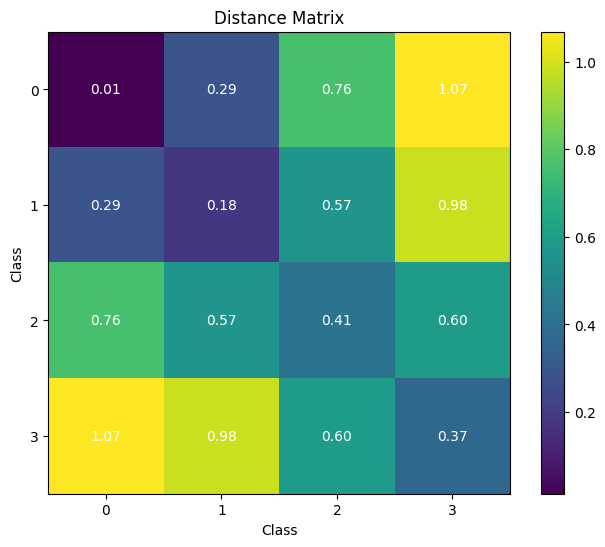

In [9]:
distance_dict = defaultdict(list)
for i in range(N):
    for j in range(i + 1, N):
        l_i, l_j = y[i], y[j]
        distance_dict[(min(l_i, l_j), max(l_i, l_j))].append(distances[i, j] * 1000)

mean_dict = {k: np.mean(v) for k, v in distance_dict.items()}
max_index = max(max(k) for k in mean_dict.keys()) + 1
matrix = np.full((max_index, max_index), np.nan)

# Populate the distance matrix
for (i, j), distance in mean_dict.items():
    matrix[i, j] = distance
    matrix[j, i] = distance
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='none')

# Add text annotations for each cell
for i in range(max_index):
    for j in range(max_index):
        distance = matrix[i, j]
        if not np.isnan(distance):
            plt.text(j, i, f'{distance:.2f}', ha='center', va='center', color='white' if distance < 2 else 'black')

plt.title('Distance Matrix')
plt.xlabel('Class')
plt.ylabel('Class')
plt.xticks(range(max_index))
plt.yticks(range(max_index))
plt.colorbar()
plt.show()

# {k: v for k, v in mean_dict.items() if k[0] == k[1]}, {k: v for k, v in mean_dict.items() if k[0] != k[1]}

## MNIST

In [66]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

from metrics import acc
from distance_matrix import parallel_distance_matrix

SELECTED_DIGITS = [3, 4, 5, 6]

def mnist_blocks(X):
    N, h, w = X.shape
    block_size = 4
    blocks = X.reshape(N, h // block_size, block_size, w // block_size, block_size)
    blocks = blocks.transpose(0, 1, 3, 2, 4)  # reshaping for more natural block indexing
    counts = np.sum(blocks > .5, axis=(3, 4))  # assuming 255 is the white pixel value
    counts = np.reshape(counts, (counts.shape[0], -1))
    return counts

In [54]:
X_train, y_train = tfds.load('mnist', split='train', as_supervised=True, batch_size=-1)
X_train = np.reshape(X_train, X_train.shape[:-1]) / 255
X_train = np.pad(X_train, pad_width=((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0.)
X_train = mnist_blocks(X_train)
indices = np.isin(y_train, SELECTED_DIGITS)
X_train = X_train[indices]
y_train = y_train[indices]

X_test, y_test = tfds.load('mnist', split='test', as_supervised=True, batch_size=-1)
X_test = np.reshape(X_test, X_test.shape[:-1]) / 255
X_test = np.pad(X_test, pad_width=((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0.)
X_test = mnist_blocks(X_test)
indices = np.isin(y_test, SELECTED_DIGITS)
X_test = X_test[indices]
y_test = y_test[indices]

# train_distance_matrix = parallel_distance_matrix(X_train, metric='euclidean')
# test_distance_matrix = parallel_distance_matrix(X_test, metric='euclidean')

data_path = Path('datasets') / 'MNIST'
data_path.mkdir(exist_ok=True, parents=True)

np.save(data_path / 'X_train', X_train)
np.save(data_path / 'y_train', y_train)
# np.save(data_path / 'distance_matrix_train', train_distance_matrix)
np.save(data_path / 'X_test', X_test)
np.save(data_path / 'y_test', y_test)
# np.save(data_path / 'distance_matrix_test', test_distance_matrix)

X_train.shape, X_test.shape

((23312, 64), (3842, 64))

In [55]:
data_path = Path('datasets') / 'MNIST'

X_train = np.load(data_path / 'X_train.npy').astype(np.float32)
y_train = np.load(data_path / 'y_train.npy')
train_distance_matrix = np.load(data_path / 'distance_matrix_train.npy').astype(np.float32)
X_test = np.load(data_path / 'X_test.npy').astype(np.float32)
y_test = np.load(data_path / 'y_test.npy')
test_distance_matrix = np.load(data_path / 'distance_matrix_test.npy').astype(np.float32)

In [56]:
kmeans = KMeans(n_clusters=len(np.unique(y_train)))
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)
accuracy, label_mapping = acc(y_test, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_test, y_pred))

/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              precision    recall  f1-score   support

           3       0.65      0.66      0.65      1010
           4       0.80      0.69      0.74       982
           5       0.41      0.55      0.47       892
           6       0.90      0.74      0.81       958

    accuracy                           0.66      3842
   macro avg       0.69      0.66      0.67      3842
weighted avg       0.70      0.66      0.67      3842



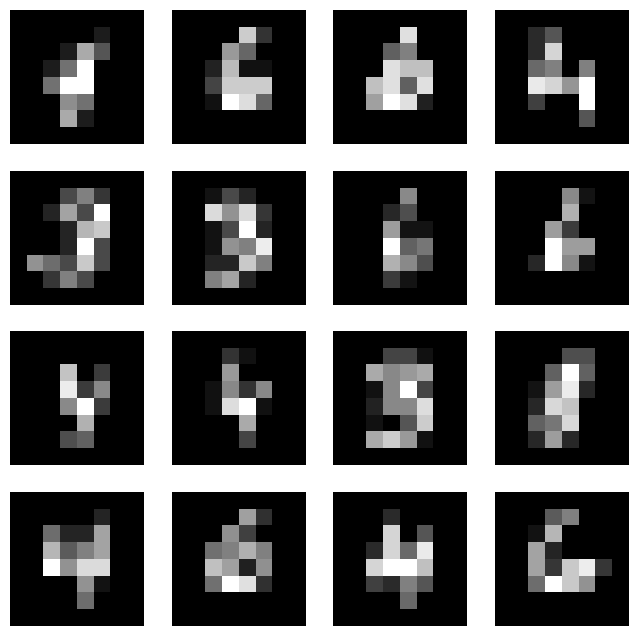

In [71]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    # Assuming each entry in grid_data is a flat array of 64 values (8x8)
    img = X_train[:16][i].reshape((8, 8))  # reshape 64 values back to an 8x8 grid
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.axis('off')

plt.show()

In [9]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_train)
y_pred = gmm.predict(X_test)
accuracy, label_mapping = acc(y_test, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.72      0.61      0.66      1010
           4       0.85      0.39      0.54       982
           5       0.39      0.69      0.50       892
           6       0.93      0.90      0.91       958

    accuracy                           0.64      3842
   macro avg       0.72      0.65      0.65      3842
weighted avg       0.73      0.64      0.65      3842



In [57]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
km = KMeans(n_clusters=10)
y_pred = km.fit_predict(X)
accuracy, label_mapping = acc(y, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y, y_pred))

/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.62      0.30      0.41       182
           2       0.84      0.83      0.84       177
           3       0.87      0.84      0.86       183
           4       0.98      0.91      0.94       181
           5       0.93      0.75      0.83       182
           6       0.97      0.98      0.98       181
           7       0.84      0.99      0.91       179
           8       0.45      0.57      0.50       174
           9       0.56      0.78      0.65       180

    accuracy                           0.79      1797
   macro avg       0.81      0.79      0.79      1797
weighted avg       0.81      0.79      0.79      1797



In [61]:
distance_matrix = parallel_distance_matrix(X, metric='euclidean')

In [68]:
tree = AgglomerativeClustering(n_clusters=20, metric='precomputed', linkage='average')
clusters = tree.fit_predict(distance_matrix)

In [69]:
cluster_label_mapping = defaultdict(list)
for label, cluster in zip(y, clusters):
    cluster_label_mapping[cluster].append(label)

for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l.tolist(), c.tolist()}")
print()
for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l[np.argmax(c)]} ({(np.max(c) / np.sum(c)):.2%})")

Cluster 0 -> ([1, 3, 6, 8, 9], [95, 13, 1, 102, 2])
Cluster 1 -> ([2], [166])
Cluster 2 -> ([1, 2, 4], [7, 10, 2])
Cluster 3 -> ([3, 5], [7, 107])
Cluster 4 -> ([3, 5, 8, 9], [162, 5, 55, 144])
Cluster 5 -> ([3, 7], [1, 158])
Cluster 6 -> ([1, 8, 9], [52, 2, 21])
Cluster 7 -> ([0, 4], [1, 172])
Cluster 8 -> ([6], [3])
Cluster 9 -> ([8], [11])
Cluster 10 -> ([0], [177])
Cluster 11 -> ([7], [4])
Cluster 12 -> ([1], [27])
Cluster 13 -> ([7], [2])
Cluster 14 -> ([2, 4, 7, 9], [1, 4, 13, 10])
Cluster 15 -> ([7], [1])
Cluster 16 -> ([1, 8], [1, 4])
Cluster 17 -> ([5, 9], [69, 2])
Cluster 18 -> ([5, 6], [1, 177])
Cluster 19 -> ([4, 7, 9], [3, 1, 1])

Cluster 0 -> 8 (47.89%)
Cluster 1 -> 2 (100.00%)
Cluster 2 -> 2 (52.63%)
Cluster 3 -> 5 (93.86%)
Cluster 4 -> 3 (44.26%)
Cluster 5 -> 7 (99.37%)
Cluster 6 -> 1 (69.33%)
Cluster 7 -> 4 (99.42%)
Cluster 8 -> 6 (100.00%)
Cluster 9 -> 8 (100.00%)
Cluster 10 -> 0 (100.00%)
Cluster 11 -> 7 (100.00%)
Cluster 12 -> 1 (100.00%)
Cluster 13 -> 7 (100.00%)
C

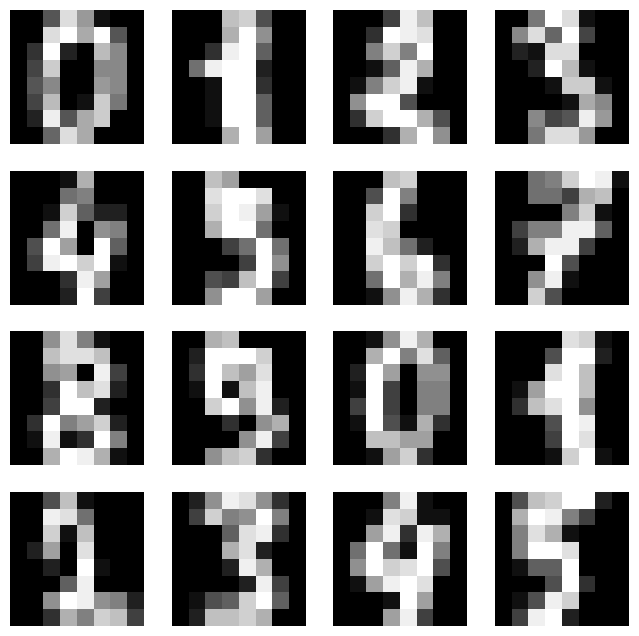

In [70]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    # Assuming each entry in grid_data is a flat array of 64 values (8x8)
    img = X[:16][i].reshape((8, 8))  # reshape 64 values back to an 8x8 grid
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.axis('off')

plt.show()